---
---
# Aesthetics - images by colours
---
---
---
#instagramaesthetics

#### Contents

0. Import packages
1. Import & transform images
2. Get dominating colours with KMeans
3. Transform colours
4. Clustering of similarities

---
## 0. Import packages
---

In [93]:
#!pip install opencv-contrib-python-headless

In [94]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import cv2
import numpy as np
import pandas as pd
import pickle
import glob
from PIL import Image
from skimage import io
from skimage.color import rgb2lab, deltaE_cie76, deltaE_ciede2000

---
## 1. Import & transform images
---

In [95]:
# import the os module
import os

# detect the current working directory and print it
path = os.getcwd()
try:
    os.mkdir(path+"\pklBilder")
    os.mkdir(path+"\boxBilder")
except OSError:
    print ("Creation of directories failed")
else:
    print ("Successfully created the directories")

Creation of directories failed


For improving performance, we first downsize the images

In [96]:
image_names=glob.glob("Bilder/*.jpg")

In [97]:
#resize images keeping ratio
imgs = [Image.open(file) for file in image_names]
for i in range(0,len(imgs)):
    imgs[i].thumbnail((500, 500))
    imgs[i].save(image_names[i])

In [98]:
images = [cv2.imread(file) for file in image_names]
images = [cv2.cvtColor(image, cv2.COLOR_BGR2RGB) for image in images]
images = [image.reshape((image.shape[0] * image.shape[1], 3)) for image in images]

In [99]:
def plot_image(image):
    plt.figure()
    plt.axis("off")
    plt.imshow(image)

---
## 2. Get dominating colours with KMeans
---

### Run KMeans and save to pickle files

In [100]:
for i in range(0,len(images)):
    clt = KMeans(n_clusters = 6)
    clt.fit(images[i])
    pickle.dump(clt, open("pkl"+image_names[i], "wb"))

### Read from pickle

In [102]:
images_colours=[]
for i in range(0,len(images)):
    icolour = pickle.load(open("pkl"+image_names[i], "rb"))
    images_colours.append(icolour)

In [103]:
def centroid_histogram(clt):
	# grab the number of different clusters and create a histogram
	# based on the number of pixels assigned to each cluster
	numLabels = np.arange(0, len(np.unique(clt.labels_)) + 1)
	(hist, _) = np.histogram(clt.labels_, bins = numLabels)
	# normalize the histogram, such that it sums to one
	hist = hist.astype("float")
	hist /= hist.sum()
	# return the histogram
	return hist

In [104]:
def plot_colours(hist, centroids):
	# initialize the bar chart representing the relative frequency
	# of each of the colors
	bar = np.zeros((50, 300, 3), dtype = "uint8")
	startX = 0
	# loop over the percentage of each cluster and the color of
	# each cluster
	for (percent, color) in zip(hist, centroids):
		# plot the relative percentage of each cluster
		endX = startX + (percent * 300)
		cv2.rectangle(bar, (int(startX), 0), (int(endX), 50),
			color.astype("uint8").tolist(), -1)
		startX = endX
	
	# return the bar chart
	return bar

# build a histogram of clusters and then create a figure
# representing the number of pixels labeled to each color
def plot_and_save_dominating_colours(clt,name):
    hist = centroid_histogram(clt)
    bar = plot_colours(hist, clt.cluster_centers_)

    plt.figure()
    plt.axis("off")
    plt.imshow(bar)
    plt.savefig(name,dpi=400,bbox_inches='tight')
    plt.show()

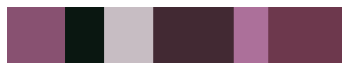

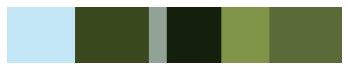

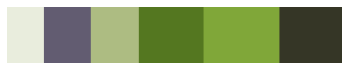

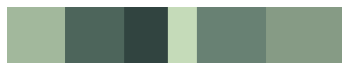

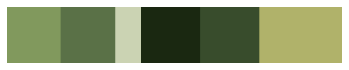

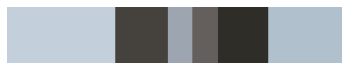

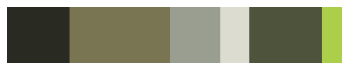

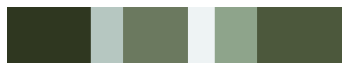

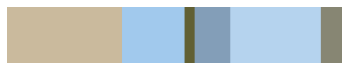

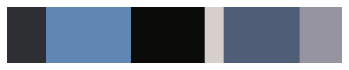

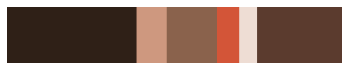

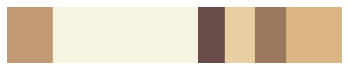

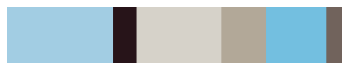

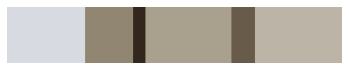

In [105]:
for i in range(0,len(images_colours)):
    plot_and_save_dominating_colours(images_colours[i],"box"+image_names[i])

In [106]:
#transform each picture to a 1x100 image of its cluster colours

def simplify_colours(clt):
    bar = np.zeros((1, 100, 3), dtype = "uint8")
    startX = 0
    for (percent, color) in zip(centroid_histogram(clt), clt.cluster_centers_):
        endX = startX + (percent * 100)
        cv2.rectangle(bar, (int(startX), 0), (int(endX), 1),
            color.astype("uint8").tolist(), -1)
        startX = endX
    return bar

---
# 3. Transform colours
---
Similarity in RGB-colour space does not equal similarity to human eyes which can be much better measured by using Lab colours.

In [107]:
lab_images=[]
for image in images_colours:
    smpl_im=simplify_colours(image)
    lab_img=rgb2lab(smpl_im)
    lab_images.append(lab_img)

## CIELAB ΔE*

In [108]:
def distance_vec(lab1,lab2):
    dist=[]
    for pxl1 in range(0,100):
        idis=[]
        for pxl2 in range(0,100):
            d=deltaE_ciede2000(lab1[0][pxl1], lab2[0][pxl2])
            idis.append(d)
        dist.append(min(idis))
    return dist               

### Define Threshold of similarity

In [109]:
similarity_threshold = 5

In [110]:
def similarity_vec(lab1,lab2):
    sim_vec=[]
    for d in distance_vec(lab1,lab2):
        if d<similarity_threshold:
            sim_vec.append(1)
        else:
            sim_vec.append(0)
    return sim_vec

In [111]:
sum(similarity_vec(lab_images[3],lab_images[3]))

100

In [112]:
len(similarity_vec(lab_images[8],lab_images[9]))

100

#### Dataframe with similarities for images

In [113]:
data=[]
for i in range(0,len(lab_images)):
    l=[]
    for j in range(0,len(lab_images)):
        sm=sum(similarity_vec(lab_images[i],lab_images[j]))
        l.append(sm)
    data.append(l)

In [114]:
data

[[100, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 100, 0, 5, 75, 0, 0, 5, 0, 0, 0, 0, 0, 0],
 [0, 0, 100, 0, 0, 0, 30, 19, 0, 0, 0, 11, 0, 0],
 [0, 23, 0, 100, 8, 0, 0, 23, 0, 0, 0, 0, 0, 0],
 [0, 67, 0, 8, 100, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 100, 15, 0, 0, 0, 0, 0, 0, 32],
 [0, 0, 27, 0, 0, 18, 100, 22, 0, 0, 0, 0, 9, 0],
 [0, 12, 25, 12, 0, 0, 26, 100, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 100, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 100, 0, 0, 5, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 100, 0, 0, 38],
 [0, 0, 44, 0, 0, 0, 0, 0, 0, 0, 0, 100, 0, 0],
 [0, 0, 0, 0, 0, 0, 26, 0, 0, 26, 0, 0, 100, 13],
 [0, 0, 0, 0, 0, 23, 0, 0, 0, 0, 4, 0, 52, 100]]

In [125]:
data=[[100, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 100, 0, 5, 75, 0, 0, 5, 0, 0, 0, 0, 0, 0],
 [0, 0, 100, 0, 0, 0, 30, 19, 0, 0, 0, 11, 0, 0],
 [0, 23, 0, 100, 8, 0, 0, 23, 0, 0, 0, 0, 0, 0],
 [0, 67, 0, 8, 100, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 100, 15, 0, 0, 0, 0, 0, 0, 32],
 [0, 0, 27, 0, 0, 18, 100, 22, 0, 0, 0, 0, 9, 0],
 [0, 12, 25, 12, 0, 0, 26, 100, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 100, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 100, 0, 0, 5, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 100, 0, 0, 38],
 [0, 0, 44, 0, 0, 0, 0, 0, 0, 0, 0, 100, 0, 0],
 [0, 0, 0, 0, 0, 0, 26, 0, 0, 26, 0, 0, 100, 13],
 [0, 0, 0, 0, 0, 23, 0, 0, 0, 0, 4, 0, 52, 100]]

In [126]:
sim=pd.DataFrame(data=data,index=image_names, columns=image_names)
sim

,Bilder\a.jpg,Bilder\giraffe.jpg,Bilder\IMG_0323.JPG,Bilder\IMG_1123.JPG,Bilder\IMG_1607.JPG,Bilder\IMG_1660.JPG,Bilder\IMG_1712.JPG,Bilder\IMG_1739.JPG,Bilder\IMG_1786.JPG,Bilder\IMG_1905.JPG,Bilder\IMG_2007.JPG,Bilder\IMG_20151220_174318.jpg,Bilder\IMG_20151222_091151.jpg,Bilder\IMG_20151228_122922.jpg
Bilder\a.jpg,100,0,0,0,0,0,0,0,0,0,0,0,0,0
Bilder\giraffe.jpg,0,100,0,5,75,0,0,5,0,0,0,0,0,0
Bilder\IMG_0323.JPG,0,0,100,0,0,0,30,19,0,0,0,11,0,0
Bilder\IMG_1123.JPG,0,23,0,100,8,0,0,23,0,0,0,0,0,0
Bilder\IMG_1607.JPG,0,67,0,8,100,0,0,0,0,0,0,0,0,0
Bilder\IMG_1660.JPG,0,0,0,0,0,100,15,0,0,0,0,0,0,32
Bilder\IMG_1712.JPG,0,0,27,0,0,18,100,22,0,0,0,0,9,0
Bilder\IMG_1739.JPG,0,12,25,12,0,0,26,100,0,0,0,0,0,0
Bilder\IMG_1786.JPG,0,0,0,0,0,0,0,0,100,0,0,0,0,0
Bilder\IMG_1905.JPG,0,0,0,0,0,0,0,0,0,100,0,0,5,0


# 4. Clustering of similarities
---

### 4.1 Clustering with KMeans

In [127]:
kmeans = KMeans(n_clusters=5, random_state=0).fit(sim)

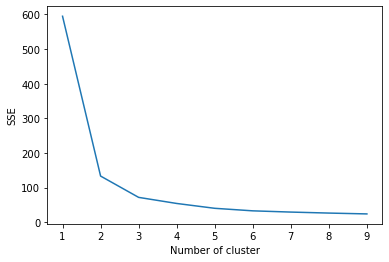

In [130]:
# find perfect number of clusters

from sklearn.datasets import load_iris

iris = load_iris()
X = pd.DataFrame(iris.data, columns=iris['feature_names'])
#print(X)
data = X[['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)']]

sse = {}
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(data)
    data["clusters"] = kmeans.labels_
    #print(data["clusters"])
    sse[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.show()

In [128]:
sim.insert(0, 'Cluster Labels', kmeans.labels_)

In [129]:
sim

,Cluster Labels,Bilder\a.jpg,Bilder\giraffe.jpg,Bilder\IMG_0323.JPG,Bilder\IMG_1123.JPG,Bilder\IMG_1607.JPG,Bilder\IMG_1660.JPG,Bilder\IMG_1712.JPG,Bilder\IMG_1739.JPG,Bilder\IMG_1786.JPG,Bilder\IMG_1905.JPG,Bilder\IMG_2007.JPG,Bilder\IMG_20151220_174318.jpg,Bilder\IMG_20151222_091151.jpg,Bilder\IMG_20151228_122922.jpg
Bilder\a.jpg,2,100,0,0,0,0,0,0,0,0,0,0,0,0,0
Bilder\giraffe.jpg,3,0,100,0,5,75,0,0,5,0,0,0,0,0,0
Bilder\IMG_0323.JPG,4,0,0,100,0,0,0,30,19,0,0,0,11,0,0
Bilder\IMG_1123.JPG,0,0,23,0,100,8,0,0,23,0,0,0,0,0,0
Bilder\IMG_1607.JPG,3,0,67,0,8,100,0,0,0,0,0,0,0,0,0
Bilder\IMG_1660.JPG,1,0,0,0,0,0,100,15,0,0,0,0,0,0,32
Bilder\IMG_1712.JPG,0,0,0,27,0,0,18,100,22,0,0,0,0,9,0
Bilder\IMG_1739.JPG,0,0,12,25,12,0,0,26,100,0,0,0,0,0,0
Bilder\IMG_1786.JPG,2,0,0,0,0,0,0,0,0,100,0,0,0,0,0
Bilder\IMG_1905.JPG,2,0,0,0,0,0,0,0,0,0,100,0,0,5,0


### 4.2 Clustering with Self-organizing map

In [131]:
#!pip install somoclu
import somoclu